In [1]:
import time
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pinocchio as pin
from src.embedding import Embedding
from src.forward_kinematics import ForwardKinematic
from src.dynamical_system import DynamicalSystem
from utils.franka_parameters import joint_limits 
from utils.visualization import visualize_robot, plot_3d_ellipsoid_from_covariance, plot_coupled_embeddings, generate_grid_coordinates

In [2]:
with open('config/environment1.json') as file:
    config = json.load(file)

In [3]:
fk = ForwardKinematic(urdf_file=config['urdf'], components_per_link=config['n_gmm_components'])
config_dim = fk.model.nq

K = 0.5 * np.eye(config_dim)
D = 1.5 * np.eye(config_dim)

config_attractor = np.array([a * np.pi/180 for a in config['attractor']])

x = np.array(config['obstacles'])

e = Embedding(dimension=config_dim, x=x, fk=fk, limits=joint_limits)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

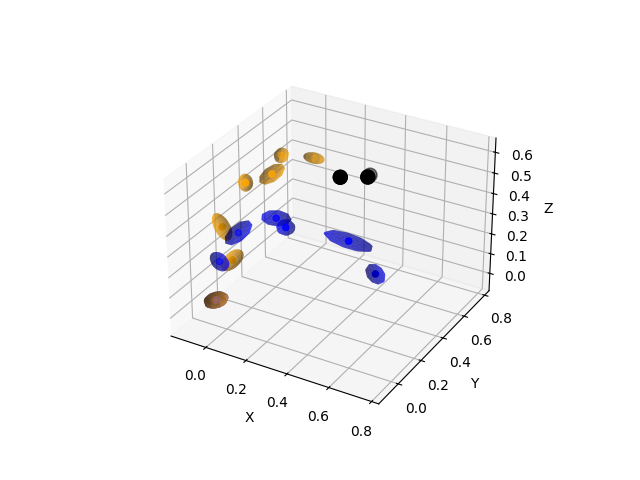

In [4]:
%matplotlib widget

config_start = np.array([a * np.pi/180 for a in config['initial_configuration']])
initial_speed = np.array(config['initial_velocities']) 

fk(config_start, initial_speed, derivation_order=0)
ax = visualize_robot(fk=fk, obstacle=x, color='blue')
fk(config_attractor, initial_speed, derivation_order=0)
visualize_robot(fk=fk, obstacle=x, color='orange', ax=ax)
plt.show()

In [5]:
q = config_start
dq = initial_speed
positions, velocities, frequencies = [], [], []
for i in range(0,3000):
    start1 = time.time()
    q, dq = ds(q, dq)
    positions.append(q)
    velocities.append(dq)
    frequencies.append(1/(time.time() - start1))
print(f'average execution frequency : {sum(frequencies)/len(frequencies):.4f} Hz')
ps = np.stack(positions)

average execution frequency : 217.2544 Hz


# Visualization

In [6]:
if not Path('.bin/franka_embedding.npy').is_file():
    grid = generate_grid_coordinates(joint_limits, resolution=5)
    a = np.zeros((grid.shape[0], grid.shape[1]+1))
    for i, q in enumerate(grid):
        a[i] = np.array([*q, e.value_only(q).sum()])
    np.save('.bin/franka_embedding.npy', a)
else:
    a = np.load('.bin/franka_embedding.npy')
    grid = a[:, :-1]

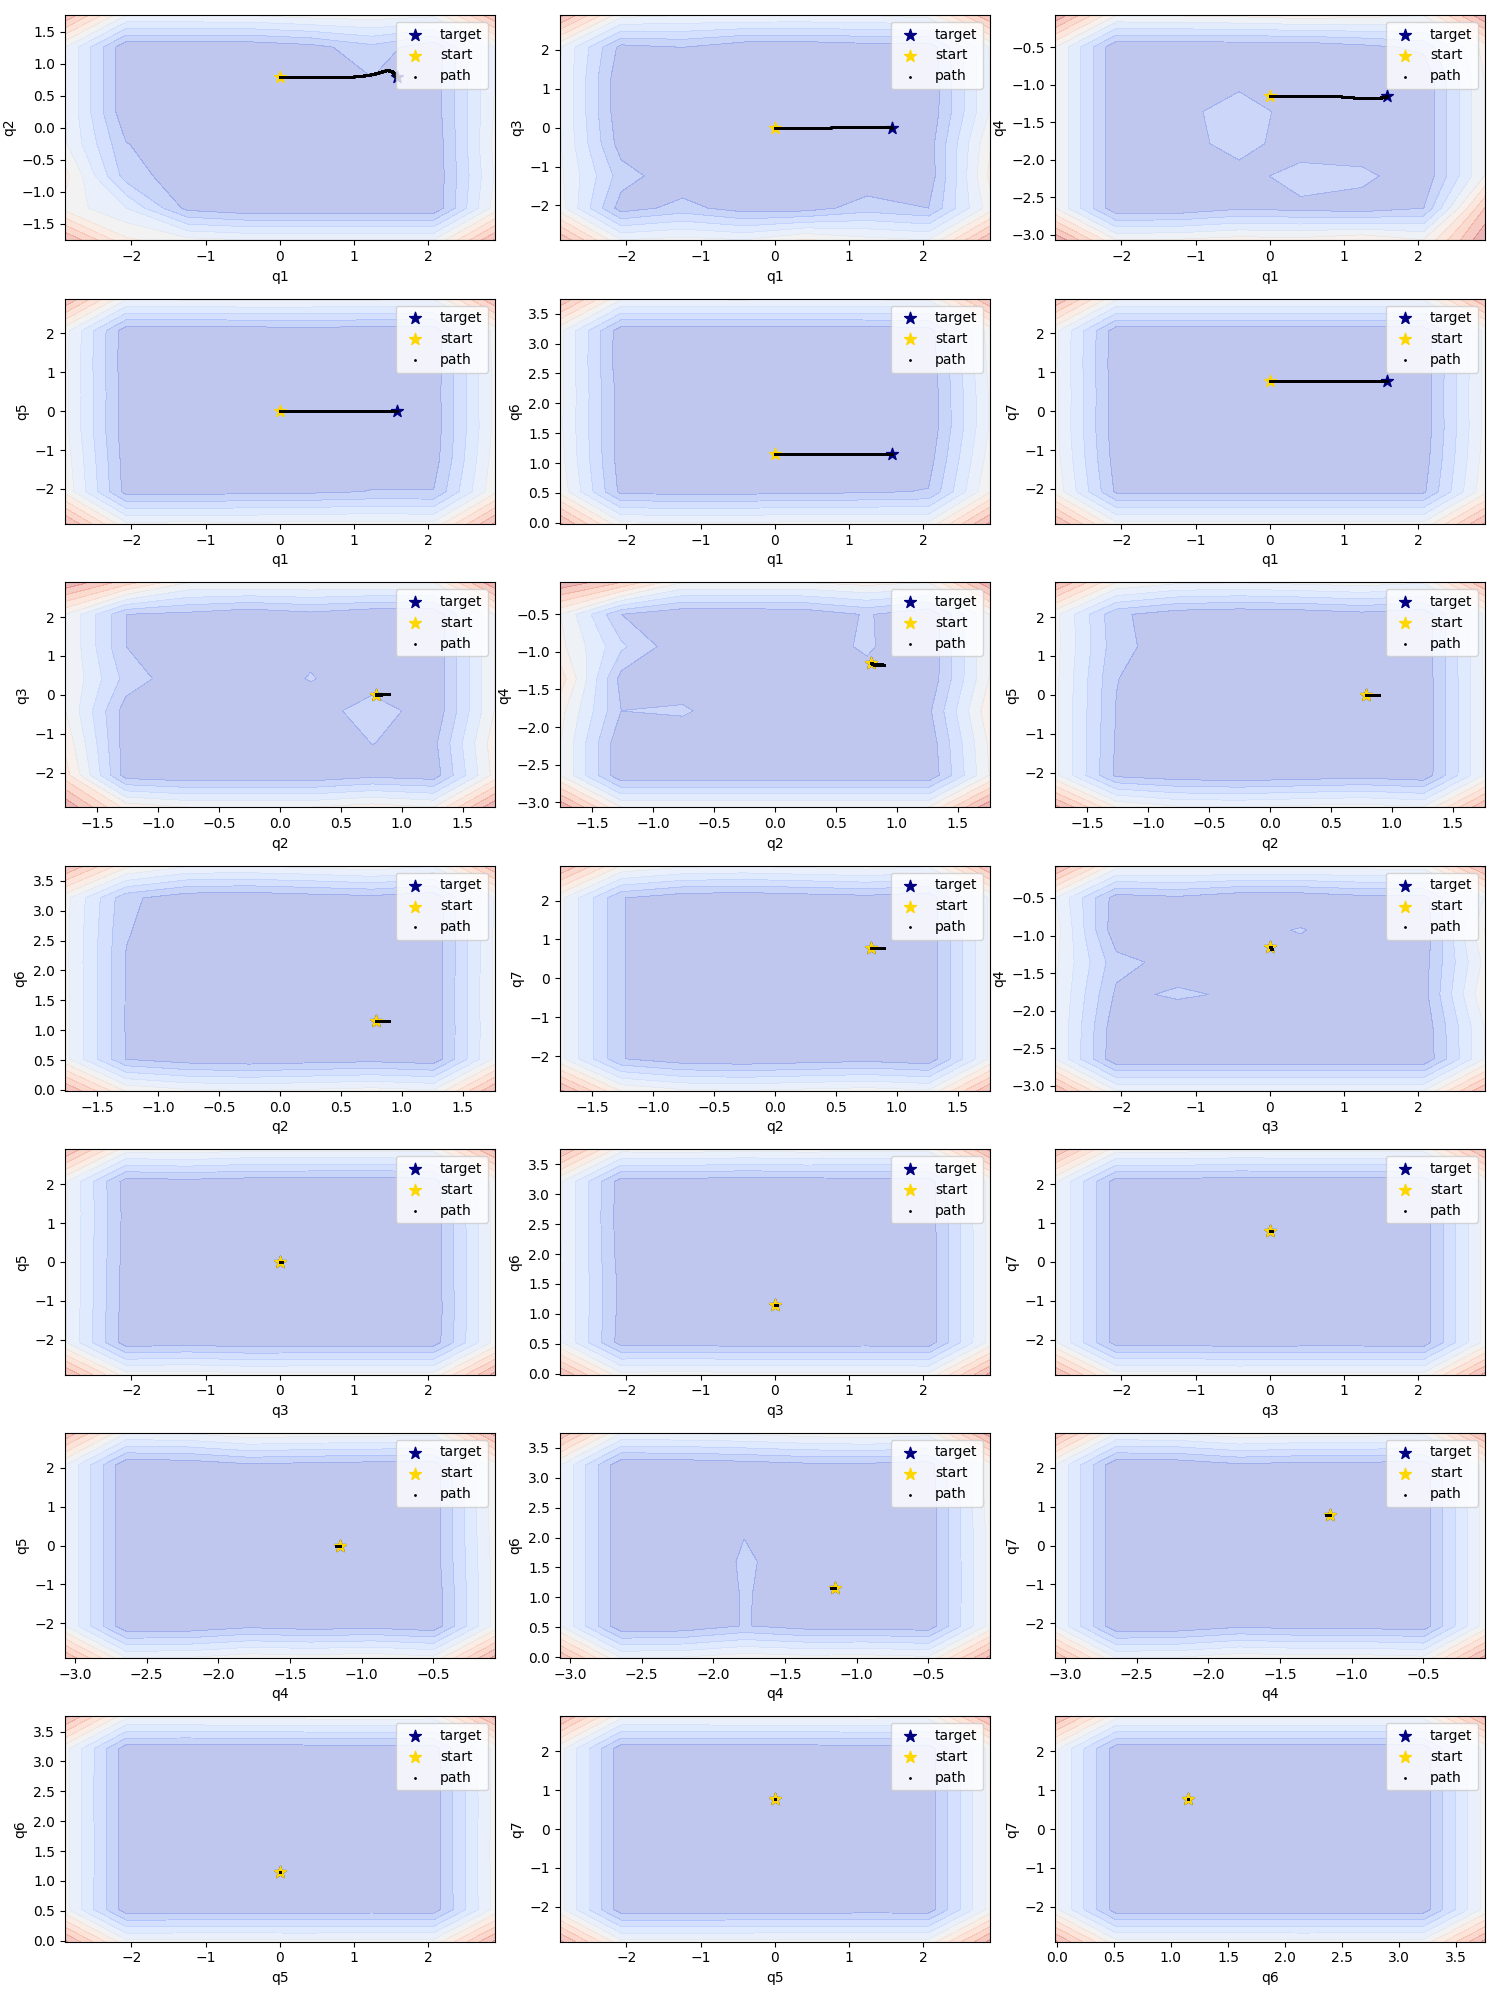

In [7]:
plot_coupled_embeddings(grid, config_attractor, embedding=a, streamlines=ps, start=config_start)
plt.show()

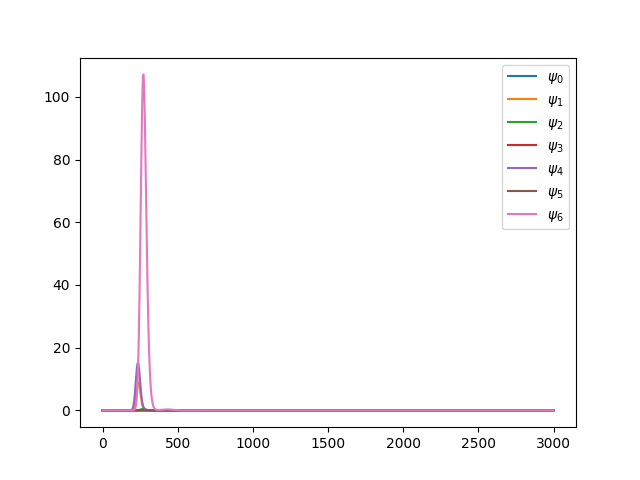

In [8]:
psi = np.stack(ds.embedding_logger)
psi = psi.reshape((psi.shape[0], 7, -1)).sum(-1)
plt.figure()
for i in range(psi.shape[1]):
    plt.plot(range(psi.shape[0]), psi[:, i], label=rf'$\psi_{i}$')
plt.legend()
plt.show()

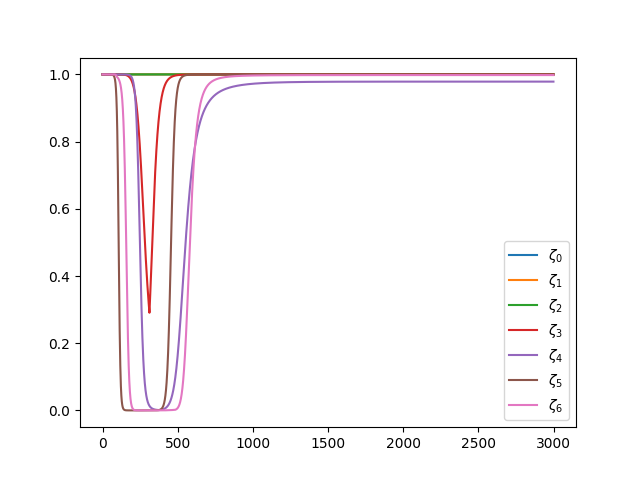

In [9]:
zeta = np.stack(ds.zeta_logger)
plt.figure()
for i in range(zeta.shape[1]):
    plt.plot(range(zeta.shape[0]), zeta[:, i], label=rf"$\zeta_{i}$")
plt.legend()
plt.show()

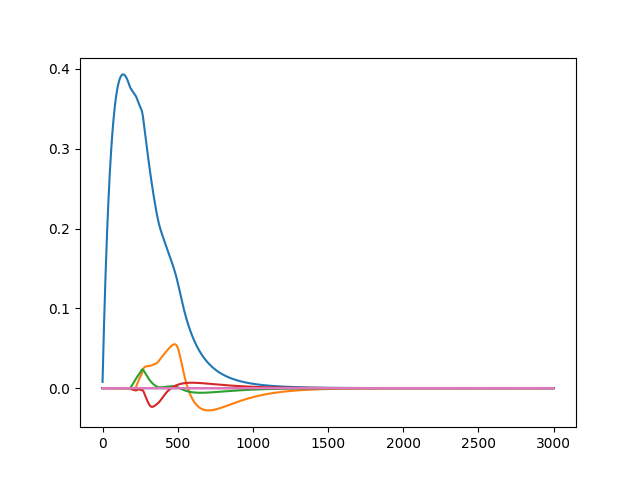

In [10]:
vel = np.stack(velocities)
plt.figure()
plt.plot(range(vel.shape[0]), vel)
plt.show()

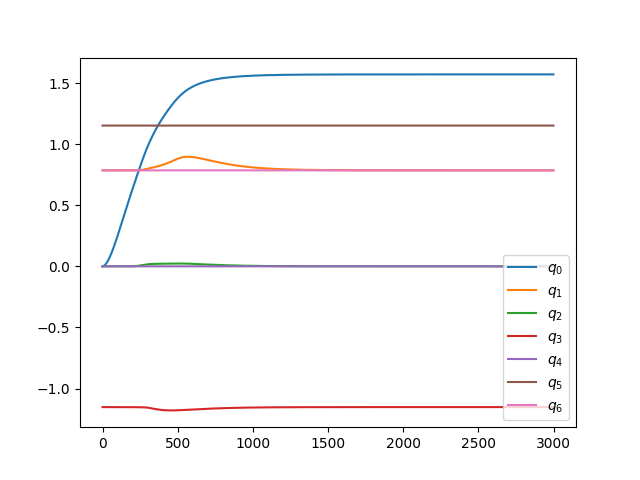

In [11]:
plt.figure()
for i in range(ps.shape[1]):
    plt.plot(range(ps.shape[0]), ps[:, i], label=rf'$q_{i}$')
plt.legend()
plt.show()

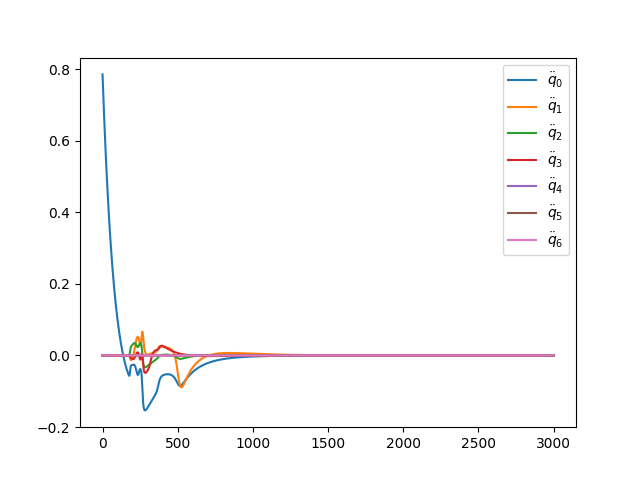

In [12]:
ddx = np.stack(ds.ddx_logger)
plt.figure()
for i in range(ddx.shape[1]):
    plt.plot(range(ddx.shape[0]), ddx[:, i], label=rf'$\ddot q_{i}$')
plt.legend()
plt.show()

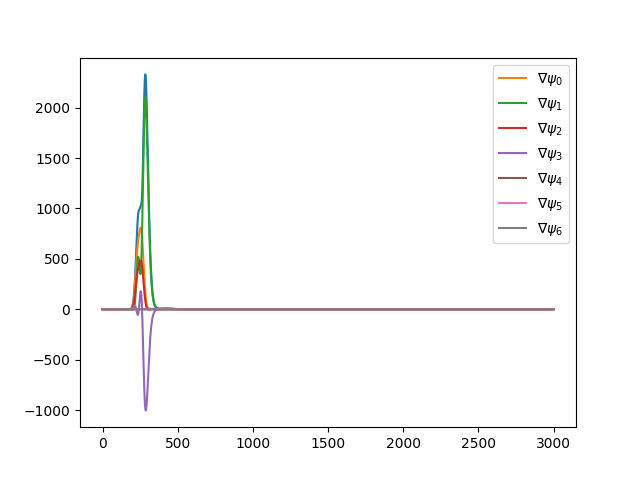

In [13]:
grad = np.stack(ds.gradient_logger)
plt.figure()
plt.plot(range(grad.shape[0]), np.linalg.norm(grad, axis=2))
for i in range(grad.shape[2]):
    plt.plot(range(grad.shape[0]), grad[:, :, i], label=rf'$\nabla\psi_{i}$')
plt.legend()
plt.show()

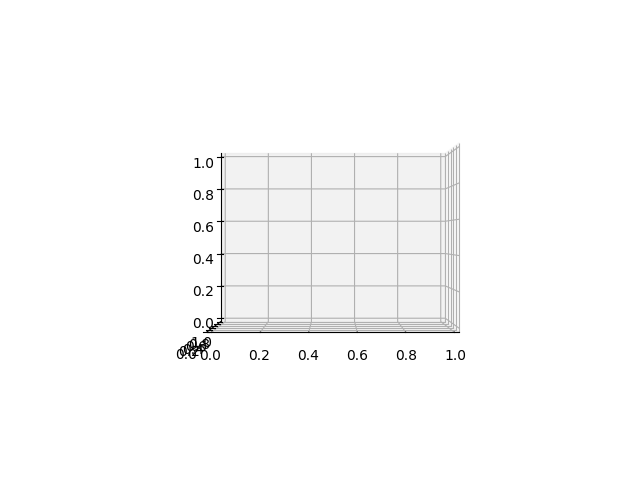

In [15]:
from matplotlib import animation

def animate_robot(i, configurations, fk: ForwardKinematic, obstacle, ax):
    ax.set_aspect('equal')
    ax.set_xlim(-0.1, 2)
    ax.clear()
    ax.scatter(obstacle[:, 0], obstacle[:, 1], obstacle[:, 2], c='black', s=100)
    q = configurations[i]
    pin.forwardKinematics(fk.model, fk.data, q)
    pin.updateFramePlacements(fk.model, fk.data)
    _ = fk(q=q, dq=np.zeros_like(q), derivation_order=0)
    ax.scatter(*(fk.mus[:, i] for i in range(3)))
    for i in range(fk.sigmas.shape[0]):
        ax.set_xlim(-0.5, 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_zlim(-0.1, 1)
        ax.set_aspect('equal')
        plot_3d_ellipsoid_from_covariance(fk.sigmas[i], center=fk.mus[i], ax=ax)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(azim=-90, elev=0)
dt = 0.004
step = int(np.round(0.016/dt))
ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, ps.shape[0], step, dtype=np.intc),fargs=(ps, fk, x, ax), interval=step*dt*1000, repeat=False)
# ani.save('vid.mp4')